# Goal: Analyze A/B Test data

In [8]:
import pandas as pd
import numpy as np
import sklearn

In [18]:
#read in data
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 350)
test_data = pd.read_csv('/Users/mengli/Desktop/OPT/项目/Data Challenge/Spainish Translation A:B test/test_table.csv')
user_data = pd.read_csv('/Users/mengli/Desktop/OPT/项目/Data Challenge/Spainish Translation A:B test/user_table.csv')

### Check data quality and merge tables

In [19]:
test_data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1


In [20]:
test_data.shape

(453321, 9)

In [21]:
user_data.head()

,user_id,sex,age,country
0,765821,M,20,Mexico
1,343561,F,27,Nicaragua
2,118744,M,23,Colombia
3,987753,F,27,Venezuela
4,554597,F,20,Spain


In [22]:
user_data.shape

(452867, 4)

In [25]:
#check whether there are repeated users 
print(test_data['user_id'].nunique()==len(test_data), user_data['user_id'].nunique()==len(user_data))

True True


In [27]:
print(len(test_data)-len(user_data))

454


In [42]:
# join
data = test_data.merge(user_data, on=['user_id'])
  
#make it a date
data['date'] = pd.to_datetime(data['date'])
data.head()

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
0,315281,2015-12-03,Direct,Web,ES,NaN,IE,1,0,M,32,Spain
1,497851,2015-12-04,Ads,Web,ES,Google,IE,0,1,M,21,Mexico
2,848402,2015-12-04,Ads,Web,ES,Facebook,Chrome,0,0,M,34,Spain
3,290051,2015-12-03,Ads,Mobile,Other,Facebook,Android_App,0,1,F,22,Mexico
4,548435,2015-11-30,Ads,Web,ES,Google,FireFox,0,1,M,19,Mexico


In [43]:
print(data.describe(include="all"))

               user_id                 date  source  device browser_language ads_channel      browser     conversion           test     sex            age country
count    452867.000000               452867  452867  452867           452867      181693       452867  452867.000000  452867.000000  452867  452867.000000  452867
unique             NaN                    5       3       2                3           5            7            NaN            NaN       2            NaN      17
top                NaN  2015-12-04 00:00:00     Ads     Web               ES    Facebook  Android_App            NaN            NaN       M            NaN  Mexico
freq               NaN               141024  181693  251316           377160       68358       154977            NaN            NaN  264485            NaN  128484
first              NaN  2015-11-30 00:00:00     NaN     NaN              NaN         NaN          NaN            NaN            NaN     NaN            NaN     NaN
last               NaN

### Check asumptions about the test
- Spain have higher user conversion rate than LatAm in control group
- The test and control group have similar user distribution

In [55]:
#split test and control group
#nothing changed in Spain, so no point in keeping those users
data = data.query('country !="Spain"')
test_group = data[data['test']==1]
control_group = data[data['test']==0]
print(
'Test group size is:', len(test_group),
'\n',
'Control group size is:', len(control_group))

Test group size is: 215774 
 Control group size is: 185311


In [47]:
#check whether Spain have better conversion rate than other LatAm
country_conversion = control_group.groupby('country')['conversion'].mean()
print(country_conversion.sort_values(ascending=False))

country
Spain          0.079719
El Salvador    0.053554
Nicaragua      0.052647
Costa Rica     0.052256
Colombia       0.052089
Honduras       0.050906
Guatemala      0.050643
Venezuela      0.050344
Peru           0.049914
Mexico         0.049495
Bolivia        0.049369
Ecuador        0.049154
Paraguay       0.048493
Chile          0.048107
Panama         0.046796
Argentina      0.015071
Uruguay        0.012048
Name: conversion, dtype: float64


In [60]:
#calculate convertion rate of test and control group
test_conversion_rate = sum(test_group['conversion'])/len(test_group)
control_conversion_rate = sum(control_group['conversion'])/len(control_group)
print(
'Test group conversion rate is:', "%.6f" % test_conversion_rate,
'\n',
'Control group conversion rate is:', "%.6f" % control_conversion_rate)


Test group conversion rate is: 0.043411 
 Control group conversion rate is: 0.048292


In [56]:
#run t test to calculate convertion rate in test and control
from scipy import stats

test = stats.ttest_ind(test_group['conversion'], control_group['conversion'], equal_var=False)
print(data.groupby('test')['conversion'].mean())

test
0    0.048292
1    0.043411
Name: conversion, dtype: float64


In [62]:
print(test.statistic)

-7.353895203080277


In [61]:
print(test.pvalue)

1.9289178577799033e-13


Findings
- Users from Spain do have higher conversion rate than users from other Spanish-speaking countries
- Test result is negative, which means site translation by local can not brought better conversion rate compared with the site translation by Spaniard
- The test is significant
    

The wierd test result might caused by
- Not enough data
- Bias in experiment data, so that test/control people are not really random

Firstly, let’s plot day by day, to see if these weird results have been constantly happening or they just started happening all of a sudden. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """


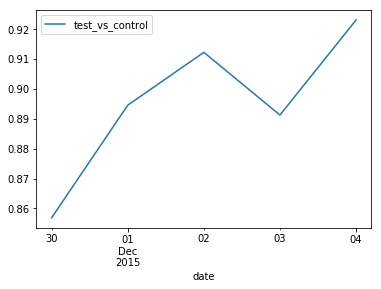

In [65]:
import matplotlib.pyplot as plt
  
#compare test and control conversion rate by day and plot it
data_test_by_day = data.groupby("date")["conversion"].agg({
"test_vs_control": lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()
}).plot()

In [ ]:
data_test_by_day = data.groupby("date")["conversion"].agg({
"test_vs_control": lambda x: x[data["test"]==1].mean()/x[data["test"]==0].mean()
}).plot()

Findings
- Test has constantly been worse than control and there is relatively little variance across days. That probably means that we do have enough data, but there was some bias in the experiment set up
- As a side note, we just ran it for 5 days. We should always run the test for at least 1 full week to capture weekly patterns, 2 weeks would be much better

### Check A/B test randomization

In [69]:
#group by source and estimate relative frequencies
data_grouped_source = data.groupby('source')['test'].agg({'frequency_test_0':lambda x: len(x[x==0]),
                                                 'frequency_control_1': lambda x: len(x[x==1])})
print(data_grouped_source/data_grouped_source.sum())

        frequency_test_0  frequency_control_1
source                                       
Ads             0.401228             0.400641
Direct          0.200949             0.199500
SEO             0.397823             0.399858


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


As we can see, relative frequency of source for different segments is the same. That is, we have basically the same proportion of users coming from Ads, Direct, and SEO in both test and control.


### Build a ML model to check randomization
Build a ML model to predict whether users are from test or control group. If users are not randomely splited, the model can be easily generated. If users are randomely splited, I can't never generate a model like this.

I would use decision tree as my model, because I can see the feature it use to split the two groups, and the feature is where randomization failed.

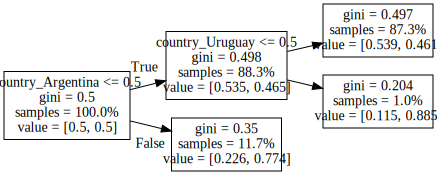

In [91]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source

#get dummies
data['date'] = data['date'].apply(str)
data_dummy = pd.get_dummies(data)
x=data_dummy.drop(['test','conversion'], axis=1)
y=data_dummy['test']
dt=DecisionTreeClassifier(min_impurity_decrease=0.001,class_weight='balanced')
dt.fit(x,y)
dot_data = export_graphviz(dt, out_file=None, feature_names=x.columns,proportion=True, rotate=True)
graph = graphviz.Source(dot_data)  
graph 

User distribution in test and control group is not the same! When users' country is Argentina, 77% of users are splited into test group. While 23% of them are splited into control group. When users are from Uruguay, the unbalance is more significant, 89% of users are splited into test group. While 11% of them are in control group. 

In [93]:
#double check Argentina and Uruguay users' proportion in test and control group
print(data_dummy.groupby('test')[['country_Argentina', 'country_Uruguay']].mean())


      country_Argentina  country_Uruguay
test                                    
0              0.050488         0.002239
1              0.173223         0.017236


The test_control_split is unbalanced. In test group, 17% of users are from Argentina and 17% of users are from Uruguay. While in control group, only 5% users are from Argentina and 2% of users are from Uruguay. 

In [109]:
#remove users from Argentina and Uruguay to get random test and control group
updated_data = data_dummy[(data_dummy['country_Argentina']==0) & (data_dummy['country_Uruguay']==0)]
updated_test_group = updated_data[updated_data['test']==1]
updated_control_group = updated_data[updated_data['test']==0]

#updated test result removing users from Argentina and Uruguay
updated_test = stats.ttest_ind(updated_test_group['conversion'], updated_control_group['conversion'], equal_var=False)

#test result using the original dataset
original_test = stats.ttest_ind(test_group['conversion'], control_group['conversion'], equal_var=False)

print(pd.DataFrame({'data_set': ['Full', 'Removed_Argentina_Uruguay'],
                   'p_value': [original_test.pvalue, updated_test.pvalue],
                   't_statistic': [original_test.statistic, updated_test.statistic]})
)


                    data_set       p_value  t_statistic
0                       Full  1.928918e-13    -7.353895
1  Removed_Argentina_Uruguay  7.200849e-01     0.358346


Findings
- Test is not significant
- Localized translation didn’t make things worse

### Nest Steps

Option1
<br>
Adjust the weight of Argentina and Uruguay users' conversion, so that the relative frequency of test and control group is the same.
<br>
Then rerun the test and check test result.
<br>
<br>
Option2
<br>
Discuss the situation with the engineer that is responsible for randomization and find out together what caused fail of randomization.
<br>
Rerun the test, and check test result.
